<a href="https://colab.research.google.com/github/Storm00212/QUANT/blob/main/Cairo_ALGO_vs_S%26P_500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install yfinance library
!pip install yfinance scipy


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
data = yf.download("SPY", start="2020-01-01", end="2024-01-01")
prices = data["Close"]

# Log returns
returns = np.log(prices / prices.shift(1)).dropna()

/tmp/ipython-input-1933066360.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [ ]:
vol = returns.rolling(20).std()
signal = returns.rolling(10).mean()

# Risk-normalized weights
weights = signal / vol
weights = weights.clip(-2, 2)

strategy_returns = weights.shift(1) * returns
strategy_returns.dropna(inplace=True)


In [ ]:
window = 60
bins = np.linspace(-0.05, 0.05, 80)

X, Y, Z = [], [], []

for i in range(window, len(strategy_returns)):
    window_data = strategy_returns[i-window:i]
    kde = gaussian_kde(window_data.values.T)
    density = kde(bins)

    X.append(np.full_like(bins, i))
    Y.append(bins)
    Z.append(density)

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

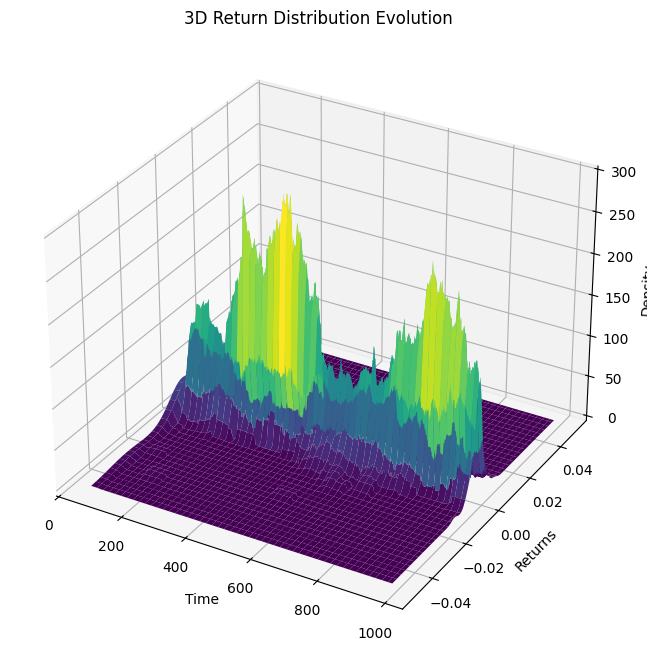

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    X,
    Y,
    Z,
    cmap="viridis",
    linewidth=0,
    antialiased=True
)

ax.set_xlabel("Time")
ax.set_ylabel("Returns")
ax.set_zlabel("Density")
ax.set_title("3D Return Distribution Evolution")

plt.show()


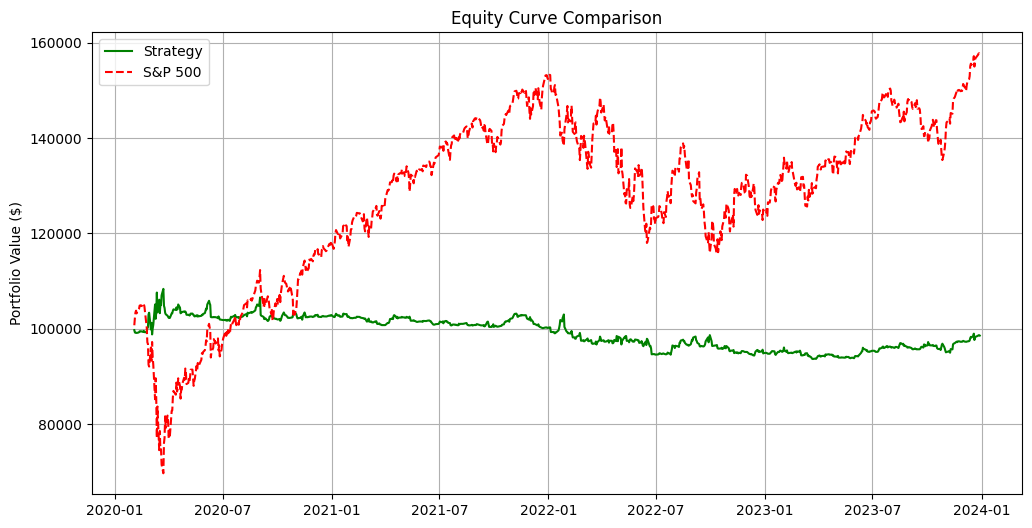

In [ ]:
capital = 100_000

strategy_equity = capital * np.exp(strategy_returns.cumsum())
buy_hold_equity = capital * np.exp(returns.loc[strategy_returns.index].cumsum())

plt.figure(figsize=(12,6))
plt.plot(strategy_equity, label="Strategy", color="green")
plt.plot(buy_hold_equity, label="S&P 500", linestyle="--", color="red")

plt.title("Equity Curve Comparison")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def stats(r):
    return {
        "CAGR": np.exp(r.mean()*252)-1,
        "Volatility": r.std()*np.sqrt(252),
        "Sharpe": r.mean()/r.std()*np.sqrt(252),
        "Skewness": r.skew(),
        "Kurtosis": r.kurtosis()
    }

stats(strategy_returns)


{'CAGR': Ticker
 SPY   -0.003635
 dtype: float64,
 'Volatility': Ticker
 SPY    0.078144
 dtype: float64,
 'Sharpe': Ticker
 SPY   -0.046607
 dtype: float64,
 'Skewness': Ticker
 SPY   -0.739956
 dtype: float64,
 'Kurtosis': Ticker
 SPY    25.07654
 dtype: float64}

# ADDING IMPROVED VERSION

In [ ]:
!pip install yfinance scipy matplotlib


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, skew
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
data = yf.download("SPY", start="2020-01-01", end="2024-01-01")
prices = data["Close"]

returns = np.log(prices / prices.shift(1)).dropna()

/tmp/ipython-input-3263666225.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("SPY", start="2020-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


In [ ]:
vol = returns.rolling(20).std()
momentum_1 = returns.rolling(5).mean()
momentum_2 = returns.rolling(10).mean()

signal_sum = momentum_1 + momentum_2

conviction = (returns > 0).rolling(10).sum()
boost = 1 + 0.1 * (conviction > 6)

R_max = 1.5
weights = R_max * (signal_sum / vol) * boost
weights = weights.clip(-2, 2)

strategy_returns = (weights.shift(1) * returns).dropna()


In [ ]:
window = 60
bins = np.linspace(-0.05, 0.05, 80)

X, Y, Z = [], [], []

for i in range(window, len(strategy_returns)):
    slice_data = strategy_returns[i-window:i]
    kde = gaussian_kde(slice_data.values.T)

    X.append(np.full_like(bins, i))
    Y.append(bins)
    Z.append(kde(bins))

X = np.array(X)
Y = np.array(Y)
Z = np.array(Z)

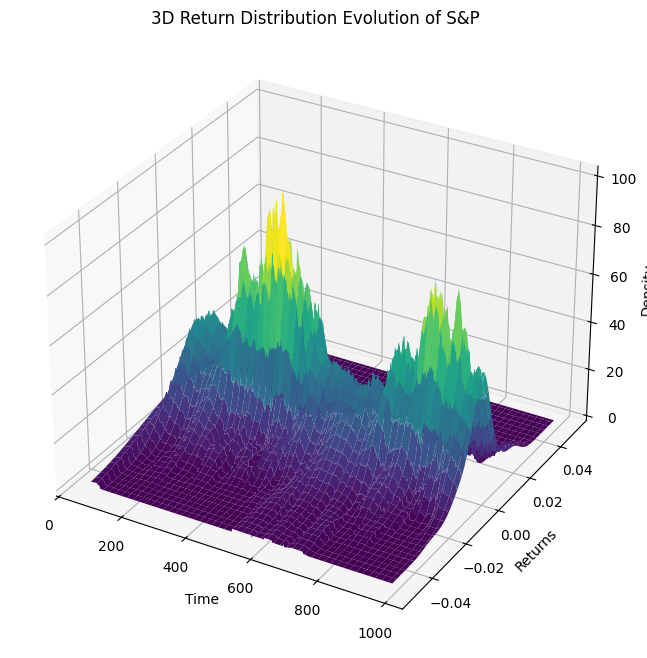

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, Z, cmap="viridis")
ax.set_xlabel("Time")
ax.set_ylabel("Returns")
ax.set_zlabel("Density")
ax.set_title("3D Return Distribution Evolution of S&P ")

plt.show()


# 3D SKEWNESS AND SURFACE

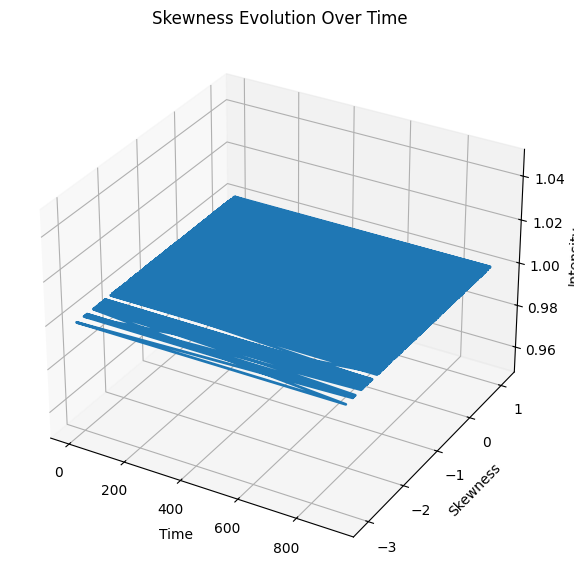

In [ ]:
skew_vals = []

for i in range(window, len(strategy_returns)):
    skew_vals.append(skew(strategy_returns[i-window:i]))

skew_vals = np.array(skew_vals)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

ax.plot(
    range(len(skew_vals)),
    skew_vals,
    np.ones_like(skew_vals),
    linewidth=2
)

ax.set_xlabel("Time")
ax.set_ylabel("Skewness")
ax.set_zlabel("Intensity")
ax.set_title("Skewness Evolution Over Time")

plt.show()


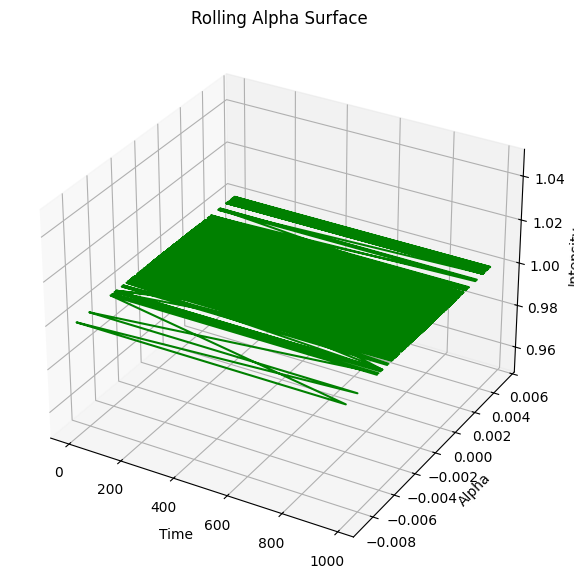

In [ ]:
benchmark = returns.loc[strategy_returns.index]
rolling_alpha = (
    strategy_returns.rolling(60).mean()
    - benchmark.rolling(60).mean()
)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

ax.plot(
    range(len(rolling_alpha)),
    rolling_alpha,
    np.ones_like(rolling_alpha),
    color="green"
)

ax.set_xlabel("Time")
ax.set_ylabel("Alpha")
ax.set_zlabel("Intensity")
ax.set_title("Rolling Alpha Surface")

plt.show()


# ANIMATED 3D RETURN DISTRIBUTION

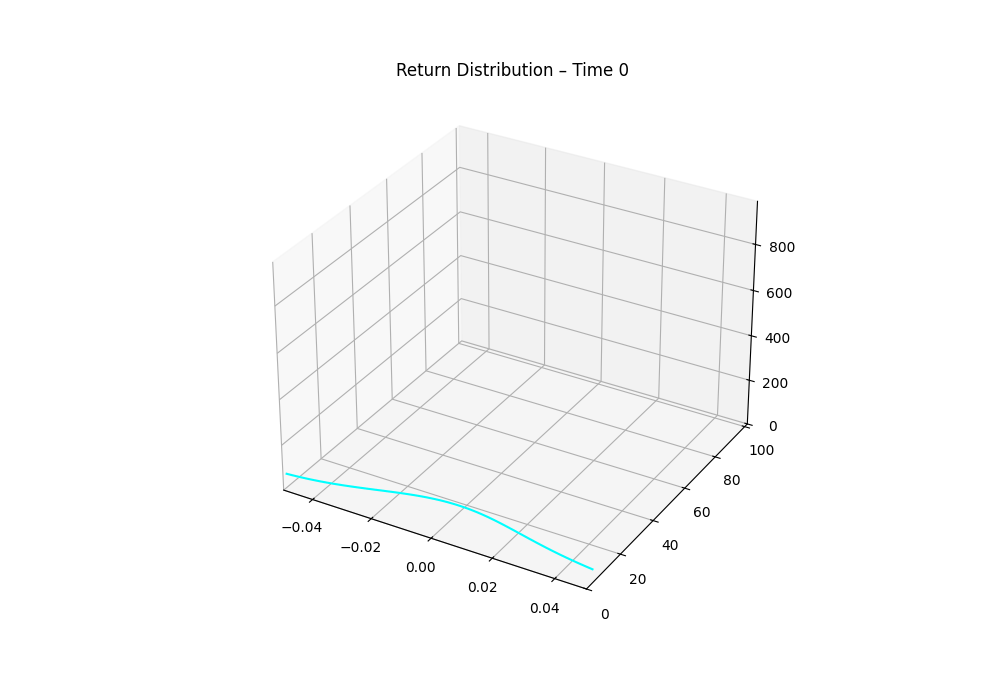

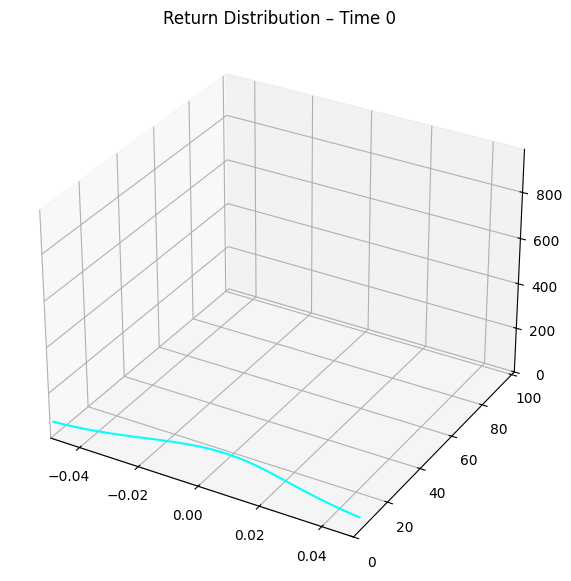

In [ ]:
from IPython.display import Image

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection="3d")

def update(frame):
    ax.clear()
    ax.plot(
        Y[frame],
        Z[frame],
        X[frame],
        color="cyan"
    )
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(0, Z.max())
    ax.set_zlim(0, X.max())

    ax.set_title(f"Return Distribution – Time {frame}")

ani = FuncAnimation(fig, update, frames=200, interval=50)

# Save the animation as a GIF and display it
ani.save('return_distribution.gif', writer='pillow', fps=20)
Image(open('return_distribution.gif','rb').read())